# Optimal Compression Level Prediction

This notebook trains an XGBoost regressor to predict the optimal compression level based on `num_users` and `cqi_midpoint` (discretized CQI) inputs.

**Key Improvement**: Data is aggregated by `(num_users, cqi_bin)` to reduce learning of random data due to per-user variations within the same scenario.

**Optimal Compression**: The compression level that gives the best QoE (lowest possible MSE while maintaining ≥80% delay_reliability).

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Load and Explore Dataset

In [4]:
# Load the dataset
df = pd.read_csv('compression_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head(10)

Dataset shape: (9000, 11)

Columns: ['run_id', 'num_users', 'user_id', 'compression_level', 'total_frames', 'on_time_frames', 'avg_delay_ms', 'delay_reliability', 'user_satisfied', 'avg_mse', 'avg_cqi']


,run_id,num_users,user_id,compression_level,total_frames,on_time_frames,avg_delay_ms,delay_reliability,user_satisfied,avg_mse,avg_cqi
0,3,5,0,5,1074,1043,2.36529,0.971136,0,823.693,14.3871
1,3,5,1,15,1074,905,2.88003,0.842644,0,461.405,13.9843
2,3,5,2,35,1074,795,6.98294,0.740223,0,367.297,13.8456
3,3,5,3,40,1074,1028,3.38920,0.957169,0,158.289,14.8426
4,3,5,4,5,1074,948,2.66382,0.882682,0,838.900,13.9188
5,2,5,0,25,1074,966,5.54641,0.899441,0,297.589,14.2928
6,2,5,1,20,1074,876,4.49317,0.815642,0,408.719,13.8256
7,2,5,2,15,1074,920,2.82268,0.856611,0,451.542,13.9245
8,2,5,3,70,1074,981,4.10203,0.913408,0,128.663,14.6198
9,2,5,4,10,1074,795,14.79070,0.740223,0,631.140,13.9172


In [5]:
# Basic statistics
df.describe()

,run_id,num_users,user_id,compression_level,total_frames,on_time_frames,avg_delay_ms,delay_reliability,user_satisfied,avg_mse,avg_cqi
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.0,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,678.277778,7.888889,3.444444,42.726667,1074.0,791.754000,5.669456,0.737201,0.005444,426.427431,14.214134
std,337.584355,1.663051,2.454661,23.080464,0.0,193.921789,2.353796,0.180560,0.073589,158.103725,0.339801
min,1.000000,5.000000,0.000000,5.000000,1074.0,57.000000,2.322110,0.053073,0.000000,96.972300,13.219100
25%,408.000000,7.000000,1.000000,25.000000,1074.0,667.000000,3.636355,0.621043,0.000000,317.882250,13.962500
50%,713.000000,8.000000,3.000000,45.000000,1074.0,826.000000,5.680715,0.769088,0.000000,393.893500,14.084600
75%,973.000000,9.000000,5.000000,65.000000,1074.0,951.000000,7.094660,0.885475,0.000000,512.526250,14.427775
max,1200.000000,10.000000,9.000000,80.000000,1074.0,1074.000000,29.093000,1.000000,1.000000,948.799000,14.999600


In [6]:
# Available compression levels
COMPRESSION_LEVELS = sorted(df['compression_level'].unique())
print(f"Compression levels: {COMPRESSION_LEVELS}")
print(f"Number of unique compression levels: {len(COMPRESSION_LEVELS)}")

Compression levels: [np.int64(5), np.int64(10), np.int64(15), np.int64(20), np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50), np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80)]
Number of unique compression levels: 16


## 2. Define CQI Bins and Calculate Optimal Compression Level

To reduce learning of random data, we aggregate scenarios by:
- **Number of users** (`num_users`)
- **CQI ranges** (discrete bins of `avg_cqi`)

This ensures that similar network conditions are grouped together, rather than treating each run independently.

For each unique scenario (defined by `num_users`, `cqi_bin`), we find the compression level that:
1. **First**: Satisfies delay_reliability ≥ 80%
2. **Then**: Minimizes avg_mse among those satisfying the constraint

If no compression level meets reliability, we pick the one with highest reliability (fallback).

In [7]:
def find_optimal_compression(group):
    """
    Find optimal compression for a given (num_users, cqi_bin) scenario.
    Returns the compression level with lowest MSE among those with >=80% reliability.
    Falls back to highest reliability if none meet threshold.
    """
    RELIABILITY_THRESHOLD = 0.80
    
    # Filter rows meeting reliability constraint
    reliable = group[group['delay_reliability'] >= RELIABILITY_THRESHOLD]
    
    if len(reliable) > 0:
        # Pick the one with minimum MSE
        best_row = reliable.loc[reliable['avg_mse'].idxmin()]
    else:
        # Fallback: pick highest reliability
        # Handle potential all-NA case by using dropna first
        valid_rows = group.dropna(subset=['delay_reliability'])
        if len(valid_rows) > 0:
            best_row = valid_rows.loc[valid_rows['delay_reliability'].idxmax()]
        else:
            # If all NA, just return the first row's compression level
            best_row = group.iloc[0]
    
    return best_row['compression_level']

# Define CQI bins to discretize the avg_cqi values
# CQI typically ranges from 0-15, but looking at our data, it's ~13-15
# We'll create bins of width 0.5 to balance granularity and sample size
CQI_BIN_WIDTH = 0.05
cqi_min = df['avg_cqi'].min()
cqi_max = df['avg_cqi'].max()

# Create bin edges
import numpy as np
cqi_bins = np.arange(np.floor(cqi_min * 2) / 2, np.ceil(cqi_max * 2) / 2 + CQI_BIN_WIDTH, CQI_BIN_WIDTH)
cqi_labels = [f"{cqi_bins[i]:.1f}-{cqi_bins[i+1]:.1f}" for i in range(len(cqi_bins)-1)]

# Assign each row to a CQI bin
df['cqi_bin'] = pd.cut(df['avg_cqi'], bins=cqi_bins, labels=cqi_labels, include_lowest=True)

print(f"CQI bin edges: {cqi_bins}")
print(f"CQI bin distribution:\n{df['cqi_bin'].value_counts().sort_index()}")

# Group by (num_users, cqi_bin, compression_level) and aggregate metrics
# This aggregates similar scenarios together
# Use observed=True to avoid FutureWarning and only include observed categories
scenario_agg = df.groupby(['num_users', 'cqi_bin', 'compression_level'], observed=True).agg({
    'delay_reliability': 'mean',  # Average reliability across all samples in bin
    'avg_mse': 'mean',             # Average MSE across all samples in bin
    'avg_cqi': 'mean',             # Mean CQI for reference
    'run_id': 'count'              # Number of samples in this group
}).rename(columns={'run_id': 'sample_count'}).reset_index()

print(f"\nAggregated scenarios (num_users, cqi_bin, compression_level): {len(scenario_agg)}")
scenario_agg.head(10)

CQI bin edges: [13.   13.05 13.1  13.15 13.2  13.25 13.3  13.35 13.4  13.45 13.5  13.55
 13.6  13.65 13.7  13.75 13.8  13.85 13.9  13.95 14.   14.05 14.1  14.15
 14.2  14.25 14.3  14.35 14.4  14.45 14.5  14.55 14.6  14.65 14.7  14.75
 14.8  14.85 14.9  14.95 15.   15.05]
CQI bin distribution:
cqi_bin
13.0-13.1       0
13.1-13.1       0
13.1-13.2       0
13.2-13.2       0
13.2-13.3       2
13.3-13.3       0
13.3-13.4       0
13.4-13.4       0
13.4-13.5       1
13.5-13.5       1
13.5-13.6       5
13.6-13.6      12
13.6-13.7      25
13.7-13.7      42
13.7-13.8      74
13.8-13.8     139
13.8-13.9     310
13.9-13.9     518
13.9-14.0     854
14.0-14.0    1182
14.0-14.1     929
14.1-14.1     544
14.1-14.2     339
14.2-14.2     329
14.2-14.3     385
14.3-14.3     402
14.3-14.4     292
14.4-14.4     227
14.4-14.5     244
14.5-14.5     263
14.5-14.6     218
14.6-14.6     141
14.6-14.7     138
14.7-14.7      84
14.7-14.8     116
14.8-14.8     200
14.8-14.9     285
14.9-14.9     263
14.9-15.0     

,num_users,cqi_bin,compression_level,delay_reliability,avg_mse,avg_cqi,sample_count
0,5,13.4-13.5,40,0.737430,352.2920,13.443500,1
1,5,13.5-13.5,20,0.689944,501.7210,13.461000,1
2,5,13.5-13.6,20,0.772812,439.3910,13.501800,1
3,5,13.5-13.6,55,0.662011,386.3870,13.515050,2
4,5,13.5-13.6,80,0.428305,586.4040,13.547500,1
5,5,13.6-13.6,20,0.613594,558.4490,13.564600,1
6,5,13.6-13.6,45,0.711359,360.4540,13.599900,1
7,5,13.6-13.7,15,0.825574,471.7190,13.626933,3
8,5,13.6-13.7,20,0.812849,411.6160,13.612900,1
9,5,13.6-13.7,40,0.636406,441.5505,13.626150,2


In [8]:
# Find optimal compression per (num_users, cqi_bin) combination
optimal_map = {}

# Use observed=True to avoid FutureWarning
for (num_users, cqi_bin), group in scenario_agg.groupby(['num_users', 'cqi_bin'], observed=True):
    optimal_comp = find_optimal_compression(group)
    optimal_map[(num_users, cqi_bin)] = optimal_comp

print(f"Optimal compression computed for {len(optimal_map)} (num_users, cqi_bin) combinations")
print(f"\nSample mappings:")
for k, v in list(optimal_map.items())[:10]:
    print(f"  num_users={k[0]}, cqi_bin={k[1]}: optimal_compression={v}")

Optimal compression computed for 149 (num_users, cqi_bin) combinations

Sample mappings:
  num_users=5, cqi_bin=13.4-13.5: optimal_compression=40
  num_users=5, cqi_bin=13.5-13.5: optimal_compression=20
  num_users=5, cqi_bin=13.5-13.6: optimal_compression=20
  num_users=5, cqi_bin=13.6-13.6: optimal_compression=45
  num_users=5, cqi_bin=13.6-13.7: optimal_compression=20
  num_users=5, cqi_bin=13.7-13.7: optimal_compression=5
  num_users=5, cqi_bin=13.7-13.8: optimal_compression=20
  num_users=5, cqi_bin=13.8-13.8: optimal_compression=20
  num_users=5, cqi_bin=13.8-13.9: optimal_compression=15
  num_users=5, cqi_bin=13.9-13.9: optimal_compression=20


In [9]:
# Create training dataset with unique (num_users, cqi_bin) -> optimal_compression
# Each row represents one (num_users, cqi_bin) scenario

# Get representative values for each (num_users, cqi_bin) scenario
# Use observed=True to avoid FutureWarning
training_data = scenario_agg.groupby(['num_users', 'cqi_bin'], observed=True).agg({
    'avg_cqi': 'mean',          # Mean CQI within this bin (for reference)
    'sample_count': 'sum'       # Total samples in this group
}).reset_index()

# Add optimal compression as target
training_data['optimal_compression'] = training_data.apply(
    lambda row: optimal_map.get((row['num_users'], row['cqi_bin']), np.nan), 
    axis=1
)

# Convert cqi_bin to a numeric feature (use the midpoint of each bin)
def bin_to_midpoint(bin_label):
    try:
        low, high = bin_label.split('-')
        return (float(low) + float(high)) / 2
    except:
        return np.nan

training_data['cqi_midpoint'] = training_data['cqi_bin'].astype(str).apply(bin_to_midpoint)

# Drop any rows with missing values
training_data = training_data.dropna().copy()

print(f"Training dataset shape: {training_data.shape}")
print(f"Unique (num_users, cqi_bin) combinations: {len(training_data)}")
print(f"\nSample distribution per combination:")
print(training_data['sample_count'].describe())
training_data.head(10)

Training dataset shape: (149, 6)
Unique (num_users, cqi_bin) combinations: 149

Sample distribution per combination:
count    149.000000
mean      60.402685
std       61.769178
min        1.000000
25%       10.000000
50%       44.000000
75%       93.000000
max      313.000000
Name: sample_count, dtype: float64


,num_users,cqi_bin,avg_cqi,sample_count,optimal_compression,cqi_midpoint
0,5,13.4-13.5,13.443500,1,40,13.45
1,5,13.5-13.5,13.461000,1,20,13.50
2,5,13.5-13.6,13.521450,4,20,13.55
3,5,13.6-13.6,13.582250,2,45,13.60
4,5,13.6-13.7,13.628040,10,20,13.65
5,5,13.7-13.7,13.667825,13,5,13.70
6,5,13.7-13.8,13.725191,27,20,13.75
7,5,13.8-13.8,13.776841,55,20,13.80
8,5,13.8-13.9,13.827815,100,15,13.85
9,5,13.9-13.9,13.876186,146,20,13.90


Optimal compression distribution:
optimal_compression
5      3
10     4
15     6
20    40
25     9
30     7
35    18
40    17
45    24
50     9
55     7
60     3
65     2
Name: count, dtype: int64


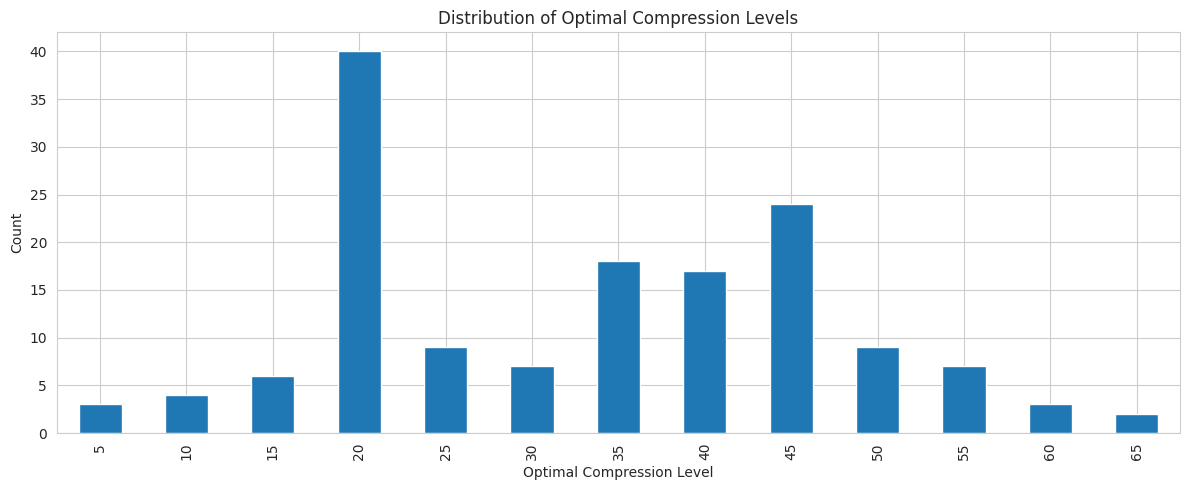

In [10]:
# Check target distribution
print("Optimal compression distribution:")
print(training_data['optimal_compression'].value_counts().sort_index())

fig, ax = plt.subplots(figsize=(12, 5))
training_data['optimal_compression'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_xlabel('Optimal Compression Level')
ax.set_ylabel('Count')
ax.set_title('Distribution of Optimal Compression Levels')
plt.tight_layout()
plt.show()

## 3. Feature Engineering & Preparation

In [11]:
# Features: num_users, cqi_midpoint (discretized CQI)
# We use cqi_midpoint which represents the center of each CQI bin

FEATURES = ['num_users', 'cqi_midpoint']
TARGET = 'optimal_compression'

X = training_data[FEATURES].copy()
y = training_data[TARGET].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures:\n{X.describe()}")

Features shape: (149, 2)
Target shape: (149,)

Features:
        num_users  cqi_midpoint
count  149.000000    149.000000
mean     7.664430     14.216779
std      1.780566      0.412254
min      5.000000     13.250000
25%      6.000000     13.900000
50%      8.000000     14.200000
75%      9.000000     14.500000
max     10.000000     15.000000


In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 119 samples
Test set: 30 samples


## 4. Train XGBoost Regressor

In [13]:
# XGBoost Regressor
model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# Train
model.fit(X_train, y_train)
print("Model trained successfully!")

Model trained successfully!


In [15]:
# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validation MAE: {-cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

Cross-validation MAE: 7.61 (+/- 2.99)


## 5. Model Evaluation

In [16]:
def snap_to_compression_level(pred):
    """
    Snap regression output to nearest valid compression level.
    Valid levels: 5, 10, 15, 20, ..., 80
    """
    valid_levels = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
    idx = np.abs(valid_levels - pred).argmin()
    return valid_levels[idx]

# Predictions
y_pred_raw = model.predict(X_test)
y_pred_snapped = np.array([snap_to_compression_level(p) for p in y_pred_raw])

print(f"Sample raw predictions: {y_pred_raw[:10].round(2)}")
print(f"Sample snapped predictions: {y_pred_snapped[:10]}")
print(f"Actual values: {y_test.values[:10]}")

Sample raw predictions: [21.71 52.61 41.38 42.09 44.5  20.61 37.65 41.69 20.62 41.76]
Sample snapped predictions: [20 55 40 40 45 20 40 40 20 40]
Actual values: [30 45 50 45 35 20 20 40 20 60]


In [17]:
# Evaluation metrics
mae_raw = mean_absolute_error(y_test, y_pred_raw)
mae_snapped = mean_absolute_error(y_test, y_pred_snapped)
rmse_raw = np.sqrt(mean_squared_error(y_test, y_pred_raw))
rmse_snapped = np.sqrt(mean_squared_error(y_test, y_pred_snapped))
r2 = r2_score(y_test, y_pred_snapped)

# Exact match accuracy
exact_match = (y_pred_snapped == y_test.values).mean() * 100
# Within 1 level (±5)
within_1 = (np.abs(y_pred_snapped - y_test.values) <= 5).mean() * 100
# Within 2 levels (±10)
within_2 = (np.abs(y_pred_snapped - y_test.values) <= 10).mean() * 100

print("=" * 50)
print("MODEL EVALUATION RESULTS")
print("=" * 50)
print(f"MAE (raw):     {mae_raw:.2f}")
print(f"MAE (snapped): {mae_snapped:.2f}")
print(f"RMSE (raw):    {rmse_raw:.2f}")
print(f"RMSE (snapped):{rmse_snapped:.2f}")
print(f"R² Score:      {r2:.4f}")
print(f"\nClassification-like Metrics:")
print(f"Exact Match:   {exact_match:.1f}%")
print(f"Within ±5:     {within_1:.1f}%")
print(f"Within ±10:    {within_2:.1f}%")
print("=" * 50)

MODEL EVALUATION RESULTS
MAE (raw):     6.73
MAE (snapped): 7.00
RMSE (raw):    8.59
RMSE (snapped):9.31
R² Score:      0.4167

Classification-like Metrics:
Exact Match:   26.7%
Within ±5:     60.0%
Within ±10:    83.3%


Feature Importance:
        Feature  Importance
1  cqi_midpoint    0.718655
0     num_users    0.281345


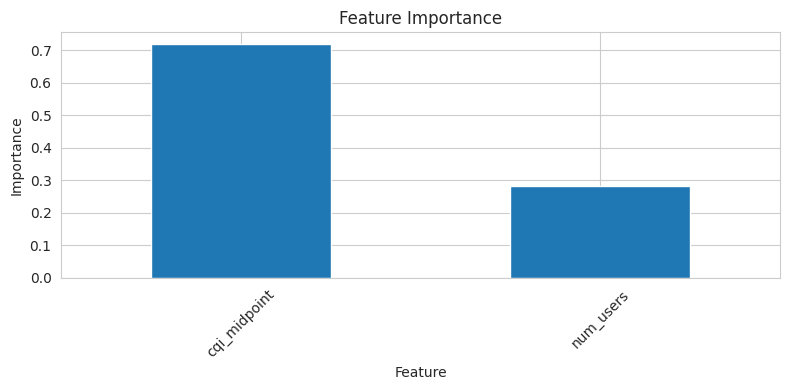

In [18]:
# Feature importance
importance = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance:")
print(importance)

fig, ax = plt.subplots(figsize=(8, 4))
importance.plot(kind='bar', x='Feature', y='Importance', ax=ax, legend=False)
ax.set_ylabel('Importance')
ax.set_title('Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

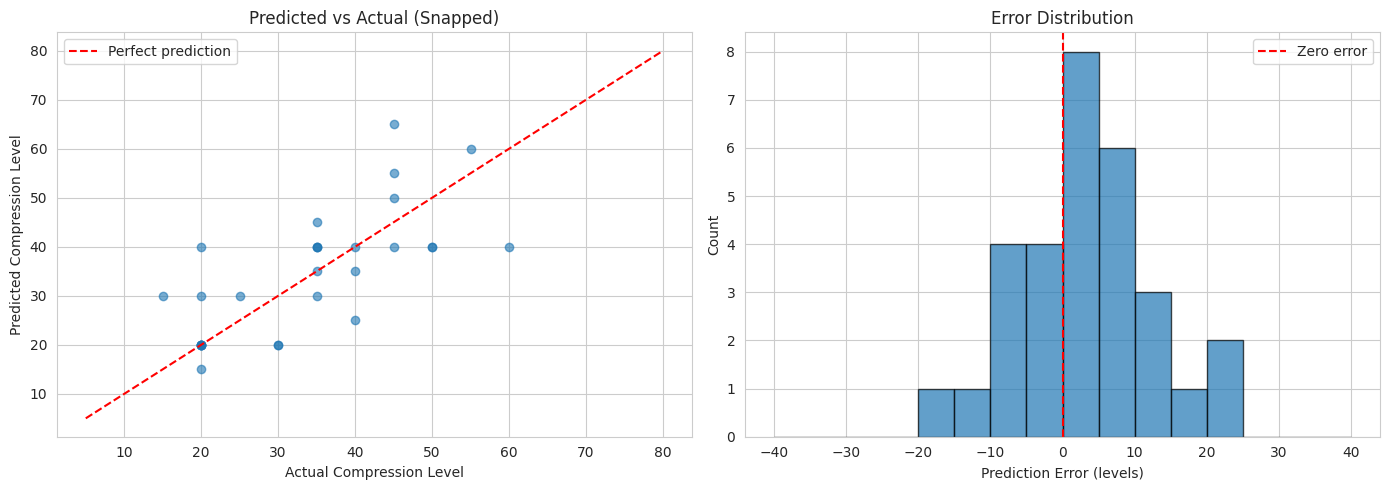

In [19]:
# Prediction vs Actual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_snapped, alpha=0.6)
axes[0].plot([5, 80], [5, 80], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Actual Compression Level')
axes[0].set_ylabel('Predicted Compression Level')
axes[0].set_title('Predicted vs Actual (Snapped)')
axes[0].legend()

# Error distribution
errors = y_pred_snapped - y_test.values
axes[1].hist(errors, bins=np.arange(-40, 45, 5), edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', label='Zero error')
axes[1].set_xlabel('Prediction Error (levels)')
axes[1].set_ylabel('Count')
axes[1].set_title('Error Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Inference Example

In [20]:
def predict_optimal_compression(num_users: int, cqi: float) -> int:
    """
    Predict optimal compression level for given network conditions.
    
    Args:
        num_users: Number of users in the cell (2-10)
        cqi: Average Channel Quality Indicator (1-15)
    
    Returns:
        Optimal compression level (5, 10, 15, ..., 80)
    """
    features = np.array([[num_users, cqi]])
    raw_pred = model.predict(features)[0]
    return snap_to_compression_level(raw_pred)

# Test examples
test_cases = [
    (2, 15.0),   # Few users, excellent CQI
    (5, 14.0),   # Medium users, good CQI
    (10, 12.0),  # Many users, moderate CQI
    (3, 8.0),    # Few users, poor CQI
    (8, 10.0),   # Many users, fair CQI
]

print("Prediction Examples:")
print("-" * 50)
for num_users, cqi in test_cases:
    pred = predict_optimal_compression(num_users, cqi)
    print(f"Users: {num_users:2d}, CQI: {cqi:5.1f} -> Optimal Compression: {pred}")

Prediction Examples:
--------------------------------------------------
Users:  2, CQI:  15.0 -> Optimal Compression: 55
Users:  5, CQI:  14.0 -> Optimal Compression: 35
Users: 10, CQI:  12.0 -> Optimal Compression: 15
Users:  3, CQI:   8.0 -> Optimal Compression: 40
Users:  8, CQI:  10.0 -> Optimal Compression: 25


## 7. Save Model

In [21]:
import joblib

# Save the model
model_path = 'compression_model.joblib'
joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")

# Quick verification
loaded_model = joblib.load(model_path)
# Test with num_users=5, cqi_midpoint=14.0
test_pred = loaded_model.predict(np.array([[5, 14.0]]))
print(f"Loaded model test prediction: {snap_to_compression_level(test_pred[0])}")

Model saved to: compression_model.joblib
Loaded model test prediction: 35


## Summary

- **Model**: XGBoost Regressor
- **Input Features**: `num_users`, `cqi_midpoint` (discretized CQI bin centers)
- **Target**: Optimal compression level (snapped to 5, 10, 15, ..., 80)
- **Aggregation**: Scenarios grouped by `(num_users, cqi_bin)` to reduce random data learning
- **Optimal Definition**: Lowest MSE while maintaining ≥80% delay reliability
- **Output**: Discrete compression level for real-time prediction